# Hourly Forecasting Carbon Intensity using MLP #

## Importing modules ##

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
import sys, os

# Dictionary to store execution times for each code block
execution_times = {}

## Processing data for hourly carbon intensity ##

In [10]:
start_time = time.time()

df = pd.read_csv('../data/df_fuel_ckan.csv')
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df.set_index('DATETIME', inplace=True)

# Resample to hourly means
df_hourly = df['CARBON_INTENSITY'].resample('H').mean().reset_index()

# Interpolate any missing hourly segments if minimal
df_hourly['CARBON_INTENSITY'] = df_hourly['CARBON_INTENSITY'].interpolate(method='linear')

# Check data
print("Hourly Data Head:")
print(df_hourly.head())
print("\nShape:", df_hourly.shape)

execution_times['Data Processing'] = time.time() - start_time
print(f"Data Processing Time: {execution_times['Data Processing']:.4f} seconds")

Hourly Data Head:
             DATETIME  CARBON_INTENSITY
0 2009-01-01 00:00:00             525.0
1 2009-01-01 01:00:00             527.0
2 2009-01-01 02:00:00             528.5
3 2009-01-01 03:00:00             531.0
4 2009-01-01 04:00:00             534.5

Shape: (148427, 2)
Data Processing Time: 0.8581 seconds


C:\Users\tianw\AppData\Local\Temp\ipykernel_620\2841562800.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df['CARBON_INTENSITY'].resample('H').mean().reset_index()


## Feature Engineering for Hourly Data ##

In [11]:
start_time = time.time()

def create_hourly_features(data):
    df = data.copy()
    
    # Time-based features
    df['hour'] = df['DATETIME'].dt.hour
    df['day_of_week'] = df['DATETIME'].dt.dayofweek
    df['month'] = df['DATETIME'].dt.month
    df['day_of_year'] = df['DATETIME'].dt.dayofyear
    df['year'] = df['DATETIME'].dt.year
    
    # Lag features (past values)
    # Lag 1 hour, 24 hours (1 day), 168 hours (1 week)
    for l in [1, 24, 168]:
        df[f'lag_{l}'] = df['CARBON_INTENSITY'].shift(l)
        
    # Rolling mean features
    # 24-hour rolling mean
    df['rolling_mean_24'] = df['CARBON_INTENSITY'].shift(1).rolling(window=24).mean()
    # 1-week rolling mean
    df['rolling_mean_168'] = df['CARBON_INTENSITY'].shift(1).rolling(window=168).mean()
    
    return df.dropna()

df_features = create_hourly_features(df_hourly)
print("Features Head:")
print(df_features.head())

execution_times['Feature Engineering'] = time.time() - start_time
print(f"Feature Engineering Time: {execution_times['Feature Engineering']:.4f} seconds")

Features Head:
               DATETIME  CARBON_INTENSITY  hour  day_of_week  month  \
168 2009-01-08 00:00:00             600.0     0            3      1   
169 2009-01-08 01:00:00             598.0     1            3      1   
170 2009-01-08 02:00:00             598.5     2            3      1   
171 2009-01-08 03:00:00             600.0     3            3      1   
172 2009-01-08 04:00:00             601.0     4            3      1   

     day_of_year  year  lag_1  lag_24  lag_168  rolling_mean_24  \
168            8  2009  605.0   604.0    525.0       599.750000   
169            8  2009  600.0   605.5    527.0       599.583333   
170            8  2009  598.0   606.5    528.5       599.270833   
171            8  2009  598.5   608.0    531.0       598.937500   
172            8  2009  600.0   609.5    534.5       598.604167   

     rolling_mean_168  
168        576.255952  
169        576.702381  
170        577.125000  
171        577.541667  
172        577.952381  
Feature Eng

## Train/Validation/Test Split ##

In [12]:
start_time = time.time()

# Split: Train < 2024, Val = 2024, Test = 2025
train_data = df_features[df_features['year'] < 2024].copy()
val_data = df_features[df_features['year'] == 2024].copy()
test_data = df_features[df_features['year'] == 2025].copy()

feature_cols = [c for c in df_features.columns if c not in ['DATETIME', 'CARBON_INTENSITY', 'year']]

X_train = train_data[feature_cols]
y_train = train_data['CARBON_INTENSITY']

X_val = val_data[feature_cols]
y_val = val_data['CARBON_INTENSITY']

X_test = test_data[feature_cols]
y_test = test_data['CARBON_INTENSITY']

print(f"Train samples: {len(X_train)}, Val samples: {len(X_val)}, Test samples: {len(X_test)}")

execution_times['Data Splitting'] = time.time() - start_time
print(f"Data Splitting Time: {execution_times['Data Splitting']:.4f} seconds")

Train samples: 131304, Val samples: 8784, Test samples: 8171
Data Splitting Time: 0.0306 seconds


## Data Scaling ##

In [13]:
start_time = time.time()

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scale features
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Scale target
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
# We don't scale y_test for prediction, but for internal eval comparison if needed
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

execution_times['Scaling'] = time.time() - start_time
print(f"Scaling Time: {execution_times['Scaling']:.4f} seconds")

Scaling Time: 0.0345 seconds


## Model Training ##

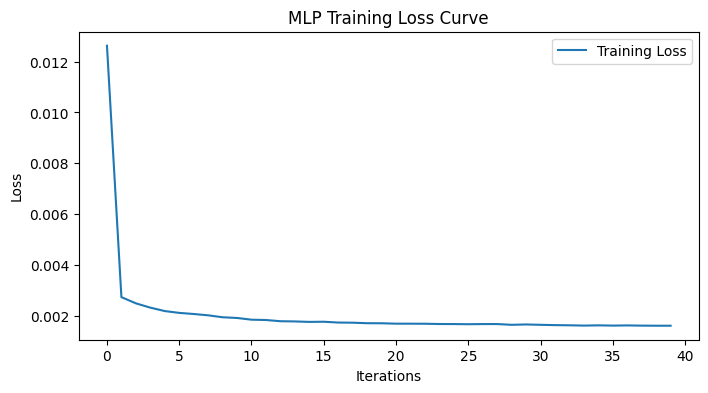

Model Training Time: 62.8246 seconds


In [14]:
start_time = time.time()

# MLP Regressor Configuration
# Using more capacity for hourly patterns
mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=20
)

history = mlp.fit(X_train_scaled, y_train_scaled)

plt.figure(figsize=(8, 4))
plt.plot(history.loss_curve_, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('MLP Training Loss Curve')
plt.legend()
plt.show()

execution_times['Model Training'] = time.time() - start_time
print(f"Model Training Time: {execution_times['Model Training']:.4f} seconds")

## Forecasting and Evaluation ##

Validation MAE: 6.07
Test MAE (2025): 6.39
Test MSE (2025): 71.31


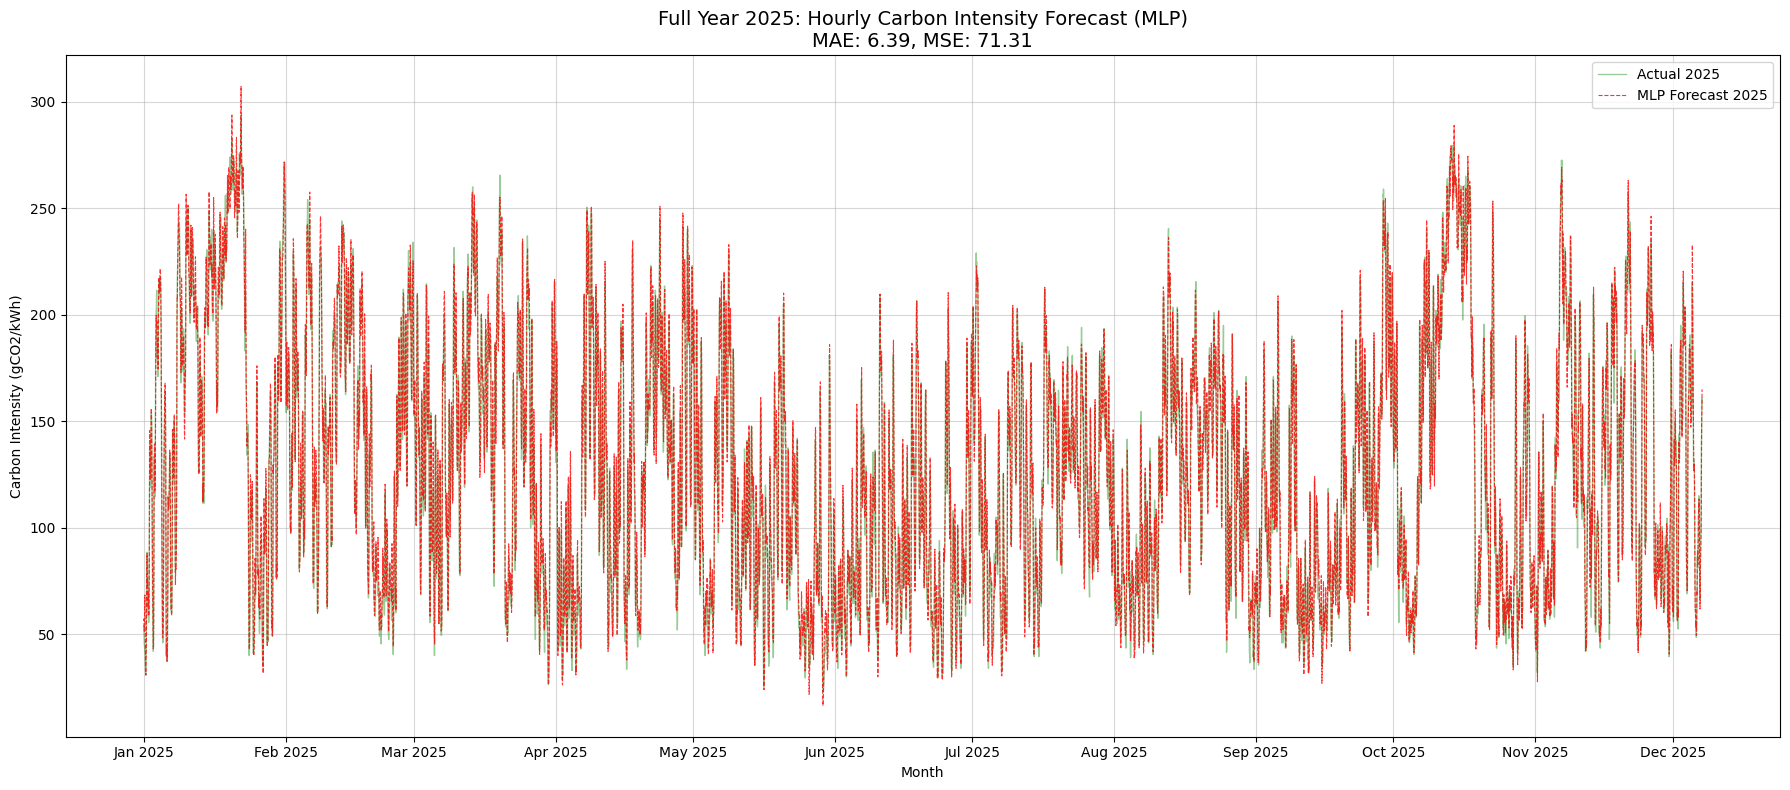

Forecasting Time: 0.4195 seconds


In [20]:
start_time = time.time()

val_pred_scaled = mlp.predict(X_val_scaled)
val_pred = scaler_y.inverse_transform(val_pred_scaled.reshape(-1, 1)).flatten()

test_pred_scaled = mlp.predict(X_test_scaled)
test_pred = scaler_y.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()

val_mae = mean_absolute_error(y_val, val_pred)
test_mae = mean_absolute_error(y_test, test_pred)
test_mse = mean_squared_error(y_test, test_pred)

print(f"Validation MAE: {val_mae:.2f}")
print(f"Test MAE (2025): {test_mae:.2f}")
print(f"Test MSE (2025): {test_mse:.2f}")

plt.figure(figsize=(18, 8))

plt.plot(test_data['DATETIME'], y_test, label='Actual 2025', color='green', alpha=0.4, linewidth=1)

plt.plot(test_data['DATETIME'], test_pred, label='MLP Forecast 2025', color='red', alpha=0.8, linestyle='--', linewidth=0.8)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.title(f'Full Year 2025: Hourly Carbon Intensity Forecast (MLP)\nMAE: {test_mae:.2f}, MSE: {test_mse:.2f}', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Carbon Intensity (gCO2/kWh)')
plt.legend(loc='upper right')
plt.grid(True, which='major', linestyle='-', alpha=0.5)

# Tighten layout and save
plt.tight_layout()
plt.show()

execution_times['Forecasting'] = time.time() - start_time
print(f"Forecasting Time: {execution_times['Forecasting']:.4f} seconds")

In [16]:
print("EXECUTION TIME SUMMARY")
total_time = 0
for task, duration in execution_times.items():
    print(f"{task}: {duration:.4f} seconds")
    total_time += duration
print(f"Total Execution Time: {total_time:.4f} seconds")

EXECUTION TIME SUMMARY
Data Processing: 0.8581 seconds
Feature Engineering: 0.0616 seconds
Data Splitting: 0.0306 seconds
Scaling: 0.0345 seconds
Model Training: 62.8246 seconds
Forecasting: 0.4728 seconds
Total Execution Time: 64.2822 seconds
